In [80]:
import numpy as np
import os
import h5py
from matplotlib import pyplot as plt
from matplotlib import gridspec as gridspec
from sklearn.svm import SVC
from sklearn.preprocessing import PowerTransformer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.decomposition import PCA
datadir = '../data'
figdir  = '../data'

fname_data = os.path.join(datadir, 'gas_data.hdf5')   

# UPDATED DATA TO BE USED:
# datasets in fname_data: 
#  - data_1point (sample all 14 gas properties at t_formation) (212x14)
#  - data_5point (sample gas properties at 5 times between start of simulation and t_formation) (212x5*14)
#  - data_10point (sample at 10 different times) (212x10*14)
#  - data_20_point (212x20*14)
#  - data_30_point
#  - data_50_point
#  - sink_IDs (212x1)
#  - labels (multiplicity shortly after formation time, before dynamical ejections from stellar systems) (212x1)
#  - labels_final (multiplicity at the end of the simulation)

# Return the labels, gas properties (sampled at 1 up to 50 times in simulation), and sink_IDs.
def loadData(fname_data):
    with h5py.File(fname_data, 'r') as f:
        sink_IDs     = f['sink_IDs'][()]      # (212,)
        labels       = f['labels'][()]        # (212,)
        labels_final = f['labels_final'][()]  # (212,)
        data_1point  = f['data_1point'][()]   # (212, 1x14)
        data_5point  = f['data_5point'][()]   # (212, 5x14)
        data_10point = f['data_10point'][()]  # (212, 10x14)
        data_20point = f['data_20point'][()]  # (212, 20x14)
        data_30point = f['data_30point'][()]  # (212, 30x14)
        data_50point = f['data_50point'][()]  # (212, 50x14)
        
        data = [data_1point, data_5point, data_10point, data_20point, data_30point, data_50point]
        
        # Replace NaN with 0
        for dset in data:
            dset[np.isnan(dset)] = 0.0
            
        # Replace inf with 0 for now.
        for dset in data:
            dset[np.isinf(dset)] = 0.0
            
        n_sinks = len(sink_IDs)
        
    labels       = np.reshape(labels, (n_sinks, 1))
    labels_final = np.reshape(labels_final, (n_sinks, 1))
        
    return labels, labels_final, data, sink_IDs

# Add option to replace labels ['2', '3', '4'] with just '2' to compare single vs. multiple systems.
def getData(fname_data, num_samples='20', use_labels='initial', relabel_multiplicity=False):
    '''
    num_samples = '1', '5', '10', '20', '30', '50'
    use_labels = 'initial' to use labels, 'final' to use labels_final
    '''
    labels_initial, labels_final, data, sink_IDs = loadData(fname_data)
    
    # Decide which multiplicity labels to use (at formation vs. end of simulation).
    if use_labels == 'initial':
        labels = labels_initial
    else:
        labels = labels_final
    
    # Replace higher-order multiplicity labels with '2'.
    if relabel_multiplicity:
        labels[(labels >= 2)] = 2
        
    y = labels
    if num_samples == '1':
        x = data[0]
    elif num_samples =='5':
        x = data[1]
    elif num_samples == '10':
        x = data[2]
    elif num_samples == '20':
        x = data[3]
    elif num_samples == '30':
        x = data[4]
    else:
        x = data[5]
    return x, y

# Preprocess data and split into train, test datasets.
def preprocessData(x, y):
    pt   = PowerTransformer(method= 'yeo-johnson', standardize= True)
    x_trans = pt.fit_transform(x)
    x_train, x_test, y_train, y_test = train_test_split(x_trans, y, train_size= 0.8, shuffle=True)
    return x_train, x_test, np.ravel(y_train), np.ravel(y_test)

def plotTraindata(ax, X, y, colors = ['r', 'g', 'b', 'y'], biLabel = True):
    pca = PCA(n_components=2)
    feature = pca.fit_transform(X)
    if biLabel == True:
        system_labels = ['Single', 'Multiple']
        for class_label in np.unique(y):
            ax.scatter(feature[y == class_label, 0], feature[y == class_label, 1], color=colors[class_label-1], 
                       label=system_labels[class_label - 1], alpha=0.5)
    else:
        for class_label in np.unique(y):
            ax.scatter(feature[y == class_label, 0], feature[y == class_label, 1], color=colors[class_label-1], 
                       label=': '.join(["Multiplicity", str(class_label)]), alpha=0.5)
    #ax.legend()
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title('Train data with label')
    handles, labels = ax.get_legend_handles_labels()
    return handles, labels

def plotSVM(x_train, y_train, x_test, y_test, figure, gridSpec, C, gammas, biLabel = True, colors = ['r', 'g', 'b', 'y']):
    pca = PCA(n_components=2)
    feature = pca.fit_transform(x_train)
    acc_matrix_train = np.zeros((len(C), len(gammas)))
    acc_matrix_test = np.zeros((len(C), len(gammas)))
    for i in range (len(C)):
        for j in range (len(gammas)):
            svm_soft = SVC(kernel = 'rbf', C = C[i], gamma = gammas[j])
            svm_soft.fit(x_train, y_train)
            y_pred_train = svm_soft.predict(x_train)
            y_pred_test = svm_soft.predict(x_test)
            acc_matrix_train[i, j] = metrics.accuracy_score(y_pred_train, y_train)
            acc_matrix_test[i, j] = metrics.accuracy_score(y_pred_test, y_test)
            
            ax = figure.add_subplot(gridSpec[i, j])
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if biLabel == True:
                system_labels = ['Single', 'Multiple']
                for class_label in np.unique(y_pred_train):
                    ax.scatter(feature[y_pred_train == class_label, 0], feature[y_pred_train == class_label, 1], color=colors[class_label - 1],
                               label=system_labels[class_label - 1], alpha=0.5)
                    ax.text(5, -3, round(acc_matrix_train[i, j], 2), horizontalalignment='left', verticalalignment='bottom')
            else:
                for class_label in np.unique(y_pred_train):
                    ax.scatter(feature[y_pred_train == class_label, 0], feature[y_pred_train == class_label, 1], color=colors[class_label - 1],
                               label=':'.join(["Multiplicity", str(class_label)]), alpha = 0.5)
                    ax.text(5, -3, round(acc_matrix_train[i, j], 2), horizontalalignment='left', verticalalignment='bottom')
            if i == len(C) - 1:
                ax.get_xaxis().set_visible(True)
                ax.set_xlabel('PC1')
            elif i == 0:
                ax.set_title('='.join(['Gamma', str(gammas[j])]), fontsize = 'medium')
            if j == 0:
                ax.get_yaxis().set_visible(True)
                ax.set_ylabel('PC2')
            elif j == len(gammas) -1:
                ax.text(ax.get_xlim()[1]+0.4, (ax.get_ylim()[0] + ax.get_ylim()[1])/2, '='.join(['C', str(C[i])]), rotation=-90,
                        verticalalignment='center')
    return acc_matrix_train, acc_matrix_test

def plotTest(test_accuracy, ax, C, gammas):
    ax.imshow(test_accuracy, vmin=0, vmax=1)
    ax.set_title('Test set accuracy')
    ax.set_xticks(np.arange(len(gammas)), gammas)
    ax.set_yticks(np.arange(len(C)), C)
    for i in range (0, len(C)):
        for j in range (0, len(gammas)):
            ax.text(j, i, round(test_accuracy[i, j], 2), verticalalignment='center', horizontalalignment='center')
    ax.set_xlabel('Gamma')
    ax.set_ylabel('C')
    #ax.figure.colorbar(im, ax)


def runSVM(x, y, axes):
    svm_soft = SVC(kernel= 'rbf', C=1.0)
    svm_soft.fit(x_train, y_train)
    y_pred_test = svm_soft.predict(x_test)
    y_pred_train = svm_soft.predict(x_train)
    print("Train data accuracy:", metrics.accuracy_score(y_pred_train, y_train))
    print("Test data accuracy:", metrics.accuracy_score(y_test, y_pred_test))

    pca = PCA(n_components=2)
    reducedX_train = pca.fit_transform(x_train)
    
    if make_fig:
        fig, ax = plt.subplots(1, 2, layout = 'tight', figsize=[10, 5])
        color = ['g', 'b', 'k', 'y']
        for i, j in enumerate(np.unique(y_train)):
            ax[0].scatter(reducedX_train[np.ravel(y_train == j),0], 
                          reducedX_train[np.ravel(y_train == j),1], 
                          c = color[i], label = np.int32(j))
            ax[1].scatter(reducedX_train[np.ravel(y_pred_train == j),0], 
                          reducedX_train[np.ravel(y_pred_train == j),1], 
                          c = color[i], label = np.int32(j))

        ax[0].set_title('Reduced train data with label')
        ax[1].set_title('Kernel SVM prediction')
        ax[0].legend()
        ax[1].legend()
        plt.show()

# SVM 

## Load data for binary classification

In [69]:
x1, y1_2class = getData(fname_data, num_samples='1', use_labels='final', relabel_multiplicity=True) # labels for 2 classes
x30, y30_2class = getData(fname_data, num_samples='30', use_labels='final', relabel_multiplicity=True)
#_, y1_4class = getData(fname_data, num_samples='1', use_labels = 'final', relabel_multiplicity=False) # labels for 4 classes
#_, y30_4class = getData(fname_data, num_samples='30', use_labels='final', relabel_multiplicity=False)

x1_train, x1_test, y1_2class_train, y1_2class_test = preprocessData(x1, y1_2class)
x30_train, x30_test, y30_2class_train, y30_2class_test = preprocessData(x30, y30_2class)

## Feature number $14\times 1$

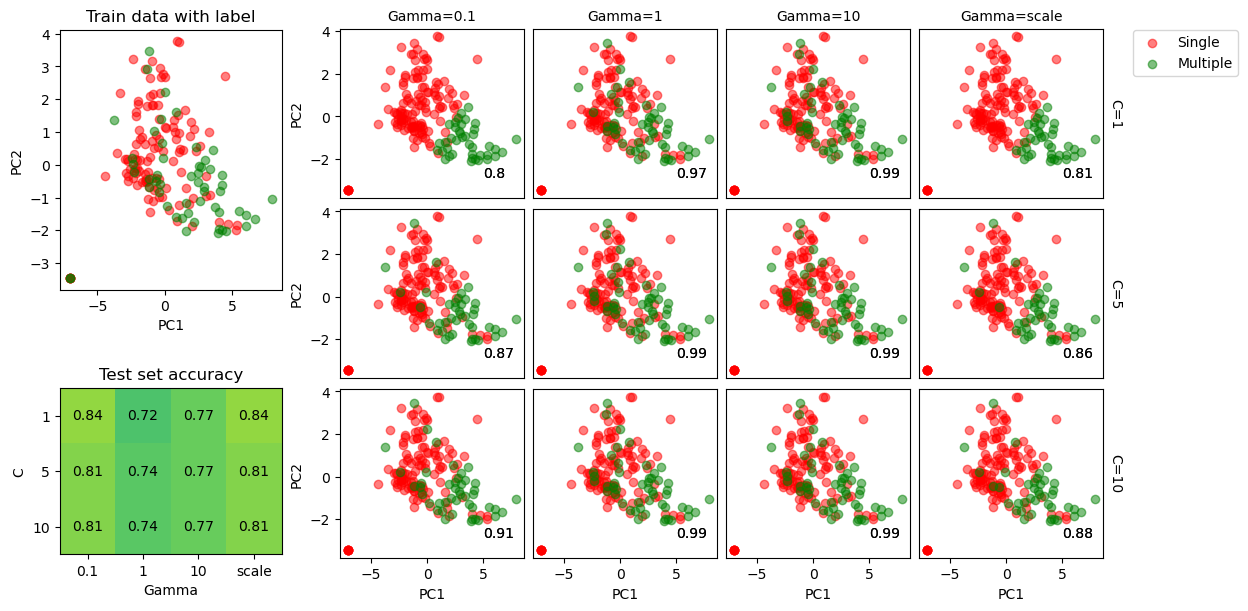

In [70]:
fig1 = plt.figure(figsize=[14, 6], layout = 'constrained')
gs1 = gridspec.GridSpec(1, 5, figure = fig1)

gs11 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs1[0:1])
ax11 = fig1.add_subplot(gs11[0])
handle, labels = plotTraindata(ax11, x1_train, y1_2class_train)

C =  [1, 5, 10]
gamma = [0.1, 1, 10, 'scale']
gs12 = gridspec.GridSpecFromSubplotSpec(len(C), len(gamma), subplot_spec=gs1[1:-1])
train_acc1, test_acc1 = plotSVM(x1_train, y1_2class_train, x1_test, y1_2class_test, figure = fig1, gridSpec = gs12, C = C, gammas = gamma)

ax12 = fig1.add_subplot(gs11[1])
plotTest(test_acc1, ax12, C, gamma)
#fig1.colorbar(im_test, ax=ax12)

#ax2 = fig1.add_subplot(gs1[1:-1])
#ax2.axis('off')
#ax2.text(-0.01, 0.5, 'PC2', rotation='vertical', verticalalignment='center', horizontalalignment='right')
fig1.legend(handle, labels, loc='upper left', bbox_to_anchor = [0.8, 0.97])
#fig1.supxlabel('PC1')
#fig1.supylabel('PC2')
plt.show()

In [71]:
fig1.savefig('../figures/SVM_1_2class.jpg', dpi=300, bbox_inches = 'tight')

## Feature number $14\times 30$

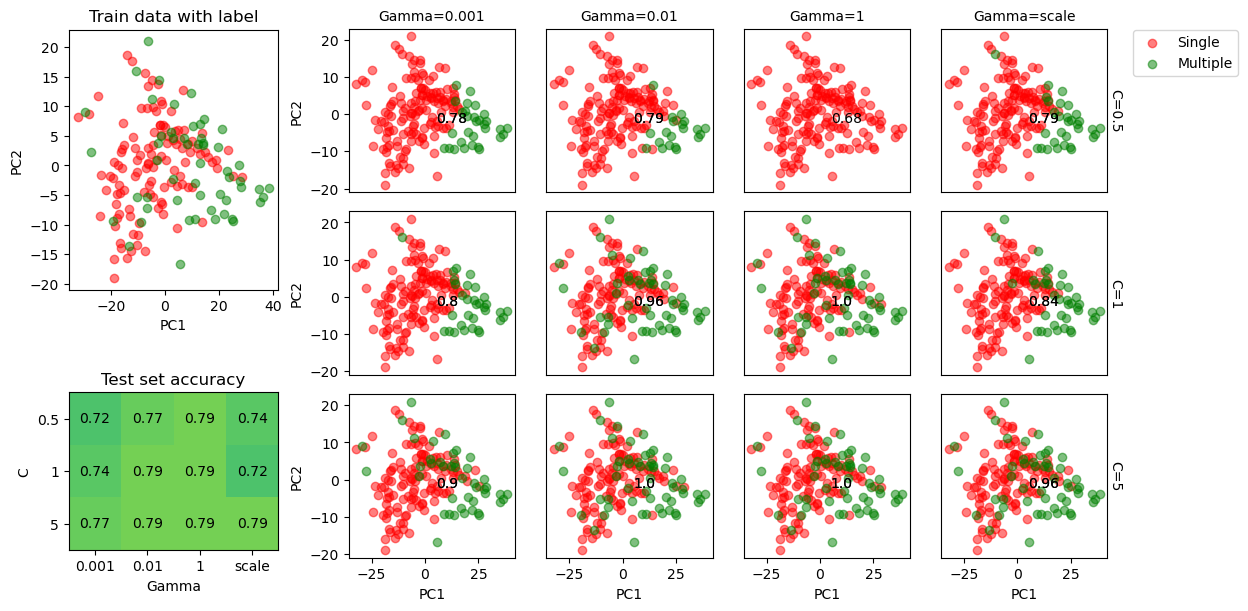

In [72]:
fig2 = plt.figure(figsize=[14, 6], layout = 'constrained')
gs1 = gridspec.GridSpec(1, 5, figure = fig2)

gs11 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs1[0:1])
ax11 = fig2.add_subplot(gs11[0])
handle, labels = plotTraindata(ax11, x30_train, y30_2class_train)

C =  [0.5, 1, 5]
gamma = [0.001, 0.01, 1, 'scale']
gs12 = gridspec.GridSpecFromSubplotSpec(len(C), len(gamma), subplot_spec=gs1[1:-1])
train_acc2, test_acc2 = plotSVM(x30_train, y30_2class_train, x30_test, y30_2class_test, figure = fig2, gridSpec = gs12, C = C, gammas = gamma)

ax12 = fig2.add_subplot(gs11[1])
plotTest(test_acc2, ax12, C, gamma)
#fig1.colorbar(im_test, ax=ax12)

#ax2 = fig1.add_subplot(gs1[1:-1])
#ax2.axis('off')
#ax2.text(-0.01, 0.5, 'PC2', rotation='vertical', verticalalignment='center', horizontalalignment='right')
fig2.legend(handle, labels, loc='upper left', bbox_to_anchor = [0.8, 0.97])
#fig1.supxlabel('PC1')
#fig1.supylabel('PC2')
plt.show()

In [73]:
fig2.savefig('../figures/SVM_30_2class.jpg', dpi=300, bbox_inches = 'tight')

## Load data for 4-class classification

In [94]:
_, y1_4class = getData(fname_data, num_samples='1', use_labels='final', relabel_multiplicity=False) # labels for 2 classes
_, y30_4class = getData(fname_data, num_samples='30', use_labels='final', relabel_multiplicity=False)
#_, y1_4class = getData(fname_data, num_samples='1', use_labels = 'final', relabel_multiplicity=False) # labels for 4 classes
#_, y30_4class = getData(fname_data, num_samples='30', use_labels='final', relabel_multiplicity=False)

x1_train, x1_test, y1_4class_train, y1_4class_test = preprocessData(x1, y1_4class)
x30_train, x30_test, y30_4class_train, y30_4class_test = preprocessData(x30, y30_4class)

## Feature number $14\times 1$

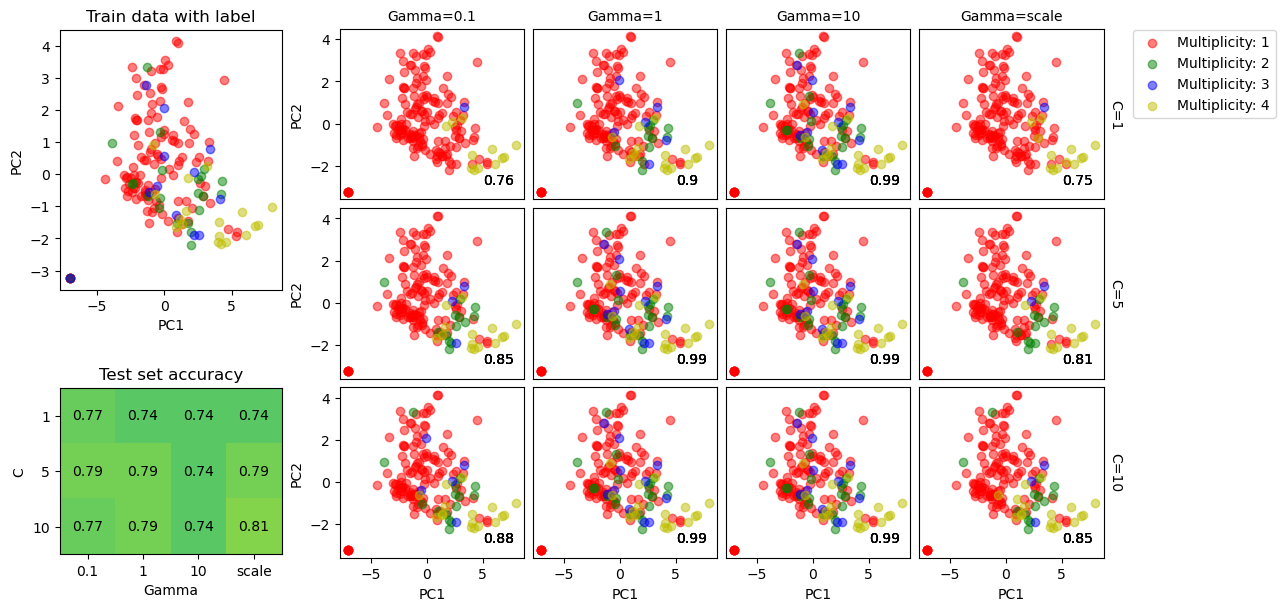

In [95]:
fig3 = plt.figure(figsize=[14, 6], layout = 'constrained')
gs1 = gridspec.GridSpec(1, 5, figure = fig3)

gs11 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs1[0:1])
ax11 = fig3.add_subplot(gs11[0])
handle, labels = plotTraindata(ax11, x1_train, y1_4class_train, biLabel=False)

C =  [1, 5, 10]
gamma = [0.1, 1, 10, 'scale']
gs12 = gridspec.GridSpecFromSubplotSpec(len(C), len(gamma), subplot_spec=gs1[1:-1])
train_acc_4class1, test_acc_4class1 = plotSVM(x1_train, y1_4class_train, x1_test, y1_4class_test, figure = fig3, gridSpec = gs12, C = C, gammas = gamma, biLabel=False)

ax12 = fig3.add_subplot(gs11[1])
plotTest(test_acc_4class1, ax12, C, gamma)
#fig1.colorbar(im_test, ax=ax12)

#ax2 = fig1.add_subplot(gs1[1:-1])
#ax2.axis('off')
#ax2.text(-0.01, 0.5, 'PC2', rotation='vertical', verticalalignment='center', horizontalalignment='right')
fig3.legend(handle, labels, loc='upper left', bbox_to_anchor = [0.8, 0.97])
#fig1.supxlabel('PC1')
#fig1.supylabel('PC2')
plt.show()

In [96]:
fig3.savefig('../figures/SVM_1_4class.jpg', dpi=300, bbox_inches = 'tight')

## Feature number $14\times 30$

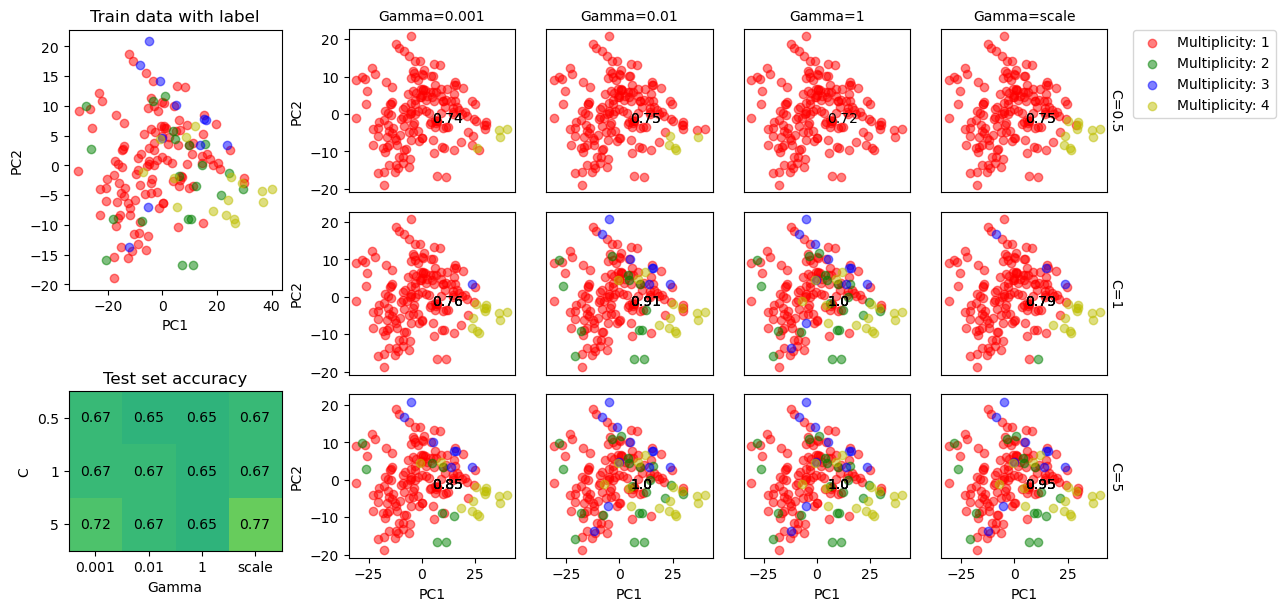

In [98]:
fig4 = plt.figure(figsize=[14, 6], layout = 'constrained')
gs1 = gridspec.GridSpec(1, 5, figure = fig4)

gs11 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs1[0:1])
ax11 = fig4.add_subplot(gs11[0])
handle, labels = plotTraindata(ax11, x30_train, y30_4class_train, biLabel=False)

C =  [0.5, 1, 5]
gamma = [0.001, 0.01, 1, 'scale']
gs12 = gridspec.GridSpecFromSubplotSpec(len(C), len(gamma), subplot_spec=gs1[1:-1])
train_acc_4class2, test_acc_4class2 = plotSVM(x30_train, y30_4class_train, x30_test, y30_4class_test, figure = fig4, gridSpec = gs12, C = C, gammas = gamma, biLabel=False)

ax12 = fig4.add_subplot(gs11[1])
plotTest(test_acc_4class2, ax12, C, gamma)
#fig1.colorbar(im_test, ax=ax12)

#ax2 = fig1.add_subplot(gs1[1:-1])
#ax2.axis('off')
#ax2.text(-0.01, 0.5, 'PC2', rotation='vertical', verticalalignment='center', horizontalalignment='right')
fig4.legend(handle, labels, loc='upper left', bbox_to_anchor = [0.8, 0.97])
#fig1.supxlabel('PC1')
#fig1.supylabel('PC2')
plt.show()

In [99]:
fig4.savefig('../figures/SVM_30_4class.jpg', dpi=300, bbox_inches = 'tight')